#### Imports

In [179]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

from sklearn.model_selection import train_test_split
from PIL import Image

# Part 0: Load in csv data and format it to images and target data

Read in csv of metadata for the images and select target data. For our target data we are selecting COVID/Non-COVID, Survival, Intubation, and Admittion to the ICU - resulting in 28 classes where class 0 = Non-COVID and class > 0 is COVID and some unique combination of the classes above. For the initial training and testing of this data, any class > 0 we set to 1 to train a binary classifier for COVID/Non-COVID

In [180]:
import csv


data = []
with open("metadata.csv") as file:
    for row in csv.reader(file):
        data.append(row)

data = data[1:]

d = {'filename': [], 'target': []}

for image in data:
    # skip volume data
    if image[22] == "volumes":
        continue
    diagnosis = image[4].split("/")
    diagnosis = diagnosis[len(diagnosis) - 1].lower()
    # set target based on meta data
    if diagnosis != "covid-19":
        if diagnosis == "todo":
            # if not classified yet target = -1
            # d['filename'].append(image[23])
            # d['target'].append(-1)
            # ignore unknown data
            continue
        else:
            # if not COVID-19 target = 0
            d['filename'].append(image[23])
            d['target'].append(0)
    else:
        # if it is COVID-19
        if image[6] == "Y":
            # if they survived
            if image[7] == "Y":
                # if they were intubated
                if image[8] == "Y":
                    # if they were put in the icu
                    d['filename'].append(image[23])
                    d['target'].append(1)
                elif image[8] == "N":
                    # if they were not put in the icu
                    d['filename'].append(image[23])
                    d['target'].append(2)
                else:
                    # if they were put in the icu is unknown
                    d['filename'].append(image[23])
                    d['target'].append(3)
            elif image[7] == "N":
                # if they were not intubated
                if image[8] == "Y":
                    # if they were put in the icu
                    d['filename'].append(image[23])
                    d['target'].append(4)
                elif image[8] == "N":
                    # if they were not put in the icu
                    d['filename'].append(image[23])
                    d['target'].append(5)
                else:
                    # if they were put in the icu is unknown
                    d['filename'].append(image[23])
                    d['target'].append(6)
            else:
                # if they were intubated is unknown
                if image[8] == "Y":
                    # if they were put in the icu
                    d['filename'].append(image[23])
                    d['target'].append(7)
                elif image[8] == "N":
                    # if they were not put in the icu
                    d['filename'].append(image[23])
                    d['target'].append(8)
                else:
                    # if they were put in the icu is unknown
                    d['filename'].append(image[23])
                    d['target'].append(9)
        elif image[6] == "N":
            # if they did not survive
            if image[7] == "Y":
                # if they were intubated
                if image[8] == "Y":
                    # if they were put in the icu
                    d['filename'].append(image[23])
                    d['target'].append(10)
                elif image[8] == "N":
                    # if they were not put in the icu
                    d['filename'].append(image[23])
                    d['target'].append(11)
                else:
                    # if they were put in the icu is unknown
                    d['filename'].append(image[23])
                    d['target'].append(12)
            elif image[7] == "N":
                # if they were not intubated
                if image[8] == "Y":
                    # if they were put in the icu
                    d['filename'].append(image[23])
                    d['target'].append(13)
                elif image[8] == "N":
                    # if they were not put in the icu
                    d['filename'].append(image[23])
                    d['target'].append(14)
                else:
                    # if they were put in the icu is unknown
                    d['filename'].append(image[23])
                    d['target'].append(15)
            else:
                # if they were intubated is unknown
                if image[8] == "Y":
                    # if they were put in the icu
                    d['filename'].append(image[23])
                    d['target'].append(16)
                elif image[8] == "N":
                    # if they were not put in the icu
                    d['filename'].append(image[23])
                    d['target'].append(17)
                else:
                    # if they were put in the icu is unknown
                    d['filename'].append(image[23])
                    d['target'].append(18)
        else:
            # if their survival is unknown
            if image[7] == "Y":
                # if they were intubated
                if image[8] == "Y":
                    # if they were put in the icu
                    d['filename'].append(image[23])
                    d['target'].append(19)
                elif image[8] == "N":
                    # if they were not put in the icu
                    d['filename'].append(image[23])
                    d['target'].append(20)
                else:
                    # if they were put in the icu is unknown
                    d['filename'].append(image[23])
                    d['target'].append(21)
            elif image[7] == "N":
                # if they were not intubated
                if image[8] == "Y":
                    # if they were put in the icu
                    d['filename'].append(image[23])
                    d['target'].append(22)
                elif image[8] == "N":
                    # if they were not put in the icu
                    d['filename'].append(image[23])
                    d['target'].append(23)
                else:
                    # if they were put in the icu is unknown
                    d['filename'].append(image[23])
                    d['target'].append(23)
            else:
                # if they were intubated is unknown
                if image[8] == "Y":
                    # if they were put in the icu
                    d['filename'].append(image[23])
                    d['target'].append(24)
                elif image[8] == "N":
                    # if they were not put in the icu
                    d['filename'].append(image[23])
                    d['target'].append(25)
                else:
                    # if they were put in the icu is unknown
                    d['filename'].append(image[23])
                    d['target'].append(26)

total = [0] * 28

for target in d['target']:
    if target == -1:
        total[27] += 1
    else:
        total[target] += 1

# set up binary classification (covid vs non-covid)
# all targets > 0 are covid
for i in range(len(d['target'])):
    if d['target'][i] > 0:
        d['target'][i] = 1

print(total)
#print(d)

file.close()


[283, 4, 3, 0, 0, 65, 0, 3, 6, 81, 8, 8, 2, 0, 1, 1, 0, 0, 18, 45, 35, 8, 0, 9, 0, 5, 261, 0]


In [181]:
print(len(d['target']))

846


# Part 1: Preprocessing for images
Load in images for the corresponding target data with PIL. Reformat all images to the same dimensions and convert them to a numpy array for the models to use (where each is a (# pixels, # pixels) array).

In [182]:
# Load in image data from filenames with PIL
img_dim = 768
images = np.empty((len(d['target']), img_dim, img_dim, 3))

for i in range(len(d['filename'])):
    image = Image.open("images/" + d['filename'][i])
    
    # resize image shape
    image = image.resize((img_dim, img_dim))
    
    # convert to RGB
    image = image.convert('RGB')
    
    images[i] = np.array(image)

# normalize values
images = images / 255.0

### Plot a loaded X-Ray to confirm successful load

Dimensions of images dataset: (846, 768, 768, 3)


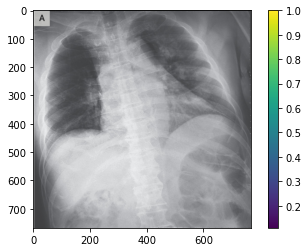

In [183]:
plt.imshow(images[0])
plt.colorbar()
print("Dimensions of images dataset:", images.shape)

### Split Images
We want to split our images for faster training with the learning algorithms. This function will split each of our images into equal parts based on a new reduced dimension parameter and create a new target dataset that matches these reduced images.

In [196]:
# create new image array and match target values for each broken image
def picSplit(red_dim, img_dim, init_images, init_targets):
    '''Function splits image into equal parts based on red_dim'''
    split_size = int(img_dim / red_dim)

    red_images = np.empty((len(init_targets) * split_size * split_size, red_dim, red_dim, 3))
    targets = np.empty((len(init_targets) * split_size * split_size))


    red_ind = 0
    for r in range(len(init_images)):
        for i in range(split_size):
            for j in range(split_size):
                start_x = i * (red_dim - 1)
                start_y = j * (red_dim - 1)
                end_x = start_x + red_dim
                end_y = start_y + red_dim
                red_image = init_images[r][start_x:end_x, start_y:end_y]

                red_images[red_ind] = np.array(red_image)
                targets[red_ind] = init_targets[r]
                red_ind += 1
    return (red_images, targets)

        

# Part 2: Deep Learning Classifier with Keras

Split the data into training and testing with sklearn. divide the images and get new corresponding targets.

In [197]:
# split data
init_x_train, init_x_test, init_y_train, init_y_test = train_test_split(images, d['target'], test_size=0.25, random_state=0)
init_y_train = np.asarray(init_y_train)
init_y_test = np.asarray(init_y_test)

In [ ]:
# split the images
red_dim  = 128
train_data = picSplit(red_dim, img_dim, init_x_train, init_y_train)
test_data = picSplit(red_dim, img_dim, init_x_test, init_y_test)

x_train = train_data[0]
y_train = train_data[1]

x_test = test_data[0]
y_test = test_data[1]

### Plot an image in all of its reduced parts to confirm image split was successful

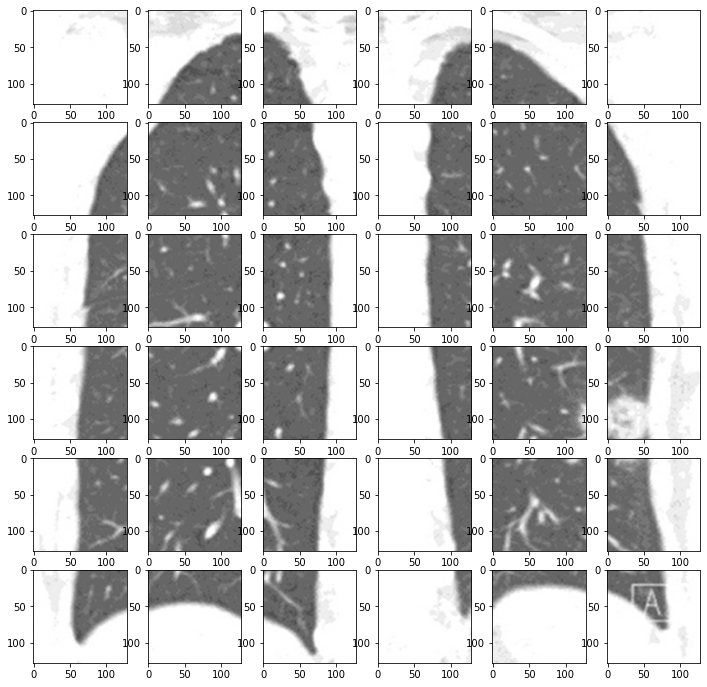

In [195]:
div = int(img_dim / red_dim)
fig, axs = plt.subplots(div, div, figsize=(12, 12))

ind = 0
for i in range(div):
    for j in range(div):
        axs[i][j].imshow(x_train[ind])
        ind += 1

Build and compile the deep learning model

In [45]:
# build model
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(red_dim, red_dim)),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(2)
])

# compile model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Train the model

In [49]:
model.fit(x_train, y_train, epochs=5)

Epoch 1/5
80/80 [==============================] - 24s 295ms/step - loss: 7963.8076 - accuracy: 0.5714
Epoch 2/5
80/80 [==============================] - 22s 276ms/step - loss: 3884.6814 - accuracy: 0.6092
Epoch 3/5
80/80 [==============================] - 22s 281ms/step - loss: 2798.4536 - accuracy: 0.6009
Epoch 4/5
80/80 [==============================] - 23s 285ms/step - loss: 2674.1575 - accuracy: 0.5875
Epoch 5/5
80/80 [==============================] - 23s 289ms/step - loss: 2132.6899 - accuracy: 0.5974


Evaluate the model with testing data

In [44]:
test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)

print('\nTest accuracy:', test_acc)

27/27 - 0s - loss: 611.7069 - accuracy: 0.6274

Test accuracy: 0.6273584961891174


# Part 3: Building a Classifier with a Convolution Neural Network

Build and compile the model

In [42]:
# build model for convolusion network
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(red_dim, red_dim, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

# add more layers
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(2))

# compile 
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [43]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 766, 766, 32)      896       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 383, 383, 32)      0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 381, 381, 64)      18496     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 190, 190, 64)      0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 188, 188, 64)      36928     
_________________________________________________________________
flatten_8 (Flatten)          (None, 2262016)           0         
_________________________________________________________________
dense_16 (Dense)             (None, 64)               

Train the model

In [44]:
history = model.fit(init_x_train, init_y_train, epochs=10, 
                    validation_data=(init_x_test, init_y_test))

Epoch 1/10
20/20 [==============================] - 217s 11s/step - loss: 7.4190 - accuracy: 0.6325 - val_loss: 1.6192 - val_accuracy: 0.6321
Epoch 2/10
20/20 [==============================] - 208s 10s/step - loss: 0.7388 - accuracy: 0.7019 - val_loss: 0.6372 - val_accuracy: 0.6698
Epoch 3/10
20/20 [==============================] - 190s 9s/step - loss: 0.6155 - accuracy: 0.7634 - val_loss: 0.6250 - val_accuracy: 0.6509
Epoch 4/10
20/20 [==============================] - 173s 9s/step - loss: 0.4334 - accuracy: 0.8360 - val_loss: 0.8198 - val_accuracy: 0.6321
Epoch 5/10
20/20 [==============================] - 171s 9s/step - loss: 0.2872 - accuracy: 0.9085 - val_loss: 1.4074 - val_accuracy: 0.6368
Epoch 6/10
20/20 [==============================] - 3204s 160s/step - loss: 0.1671 - accuracy: 0.9385 - val_loss: 1.6798 - val_accuracy: 0.6038
Epoch 7/10
20/20 [==============================] - 527s 26s/step - loss: 0.1524 - accuracy: 0.9590 - val_loss: 1.4614 - val_accuracy: 0.6038
Epoch 8

Evaluate the model with testing data and plot results

7/7 - 8s - loss: 2.9153 - accuracy: 0.6415


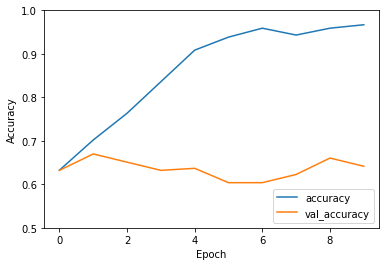

In [46]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(init_x_test,  init_y_test, verbose=2)

# Part 4: Optimization
Based on the results of the above models, we will now attempt to optimize our algorithms. Since the results indicate an overfitting of the models (high accuracy on training models and low accuracy on validation data), we will add additional data in an attempt to better generalize our models. In addition, we will be using cross validation to find a better split between our training/testing data.